# "Colorless" Artificial Reverbation
[Allpass filter from 1961 IRE paper by M. R. Schroeder and B. F. Logan](http://www2.ece.rochester.edu/courses/ECE472/resources/Papers/Schroeder_1961.pdf)


Allpass reverb from 1962 JAES paper *Natural Sounding Artificial Reverberation* by M. R. Schroeder

In [1]:
from lib.plot_utils import *
import warnings
from IPython import display
from lib.utils import process_file
import wave
from scipy import signal, fft
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%load_ext Cython


warnings.filterwarnings('ignore')


TAU = 2 * np.pi


![Allpass Delay](img/allpass_filter.png)

In [2]:
%%cython -+ 
import numpy as np
import cython


@cython.cclass
class RingBuffer:
    """Circular buffer"""
    buffer: np.double[:]
    buffer_view: np.double[:, ::1]
    length: np.uintc
    write_pointer: np.uintc
    read_pointer: np.uintc

    def __cinit__(self, length: np.uintc) -> None:
        self.buffer = np.zeros(length, dtype=np.double)
        self.buffer_view = self.buffer
        self.length = length
        self.write_pointer = 0
        self.read_pointer = 1

    @cython.ccall
    @cython.boundscheck(False)
    @cython.wraparound(False)
    def push(self, input_: np.double):
        """Push sample to delay line"""
        self.buffer_view[self.write_pointer] = input_
        self.write_pointer = (self.write_pointer + 1) % self.length
        self.read_pointer = (self.write_pointer + 1) % self.length

    @cython.ccall
    def clear(self):
        """Flush delay line, setting all values to 0.0"""
        for _index in range(self.length):
            self.push(0.0)

    @cython.boundscheck(False)
    def __getitem__(self, index: np.uintc) -> np.double:
        if index < 0:
            return self.buffer_view[(self.write_pointer + index) % self.length]

        return self.buffer_view[(self.read_pointer - index) % self.length]


@cython.cclass
class Delay:
    """Circular buffer delay"""
    interpolation: bool
    output: np.double
    delay_length: np.uintc
    delay_buffer: RingBuffer
    sample_rate: np.double
    delay_taps: np.double[:]

    def __cinit__(self, sample_rate: np.uintc, max_delay_ms: np.double, delay_taps, interpolation: str):
        self.interpolation = interpolation
        self.sample_rate = sample_rate
        self.output = 0.0
        self.delay_taps = delay_taps
        
        self.delay_length = int(max_delay_ms * (sample_rate / 1000.0) + 2)
        self.delay_buffer = RingBuffer(self.delay_length)
        self.clear()

    def __getattr__(self, output):
        return self.output

    @cython.ccall
    def tick(self, input_: np.double):
        """Run delay for 1 sample"""
        self.output = 0
        for tap in self.delay_taps:
            self.output += self.read(tap)
        self.delay_buffer.push(input_)

    @cython.ccall
    def read(self, delay_tap: np.double) -> cython.double:
        delay: np.double = delay_tap * (self.sample_rate / 1000.0)
        return self.interpolate(delay)
    
    @cython.ccall
    def interpolate(self, x_bar: np.double) -> cython.double:
        """Interpolate between two points in the delay line"""
        floor: np.uintc = int(np.floor(x_bar))
        remainder: np.uintc = x_bar - floor
        y1: np.double = self.delay_buffer[floor]
        y2: np.double = self.delay_buffer[floor + 1]
        
        if self.interpolation == 'linear':
            return y1 + ((y2 - y1) * remainder)
        
        elif self.interpolation == 'hermite':
            y0: np.double = self.delay_buffer[floor - 1]
            y3: np.double = self.delay_buffer[floor + 2]
            slope0: np.double = (y2 - y0) * 0.5
            slope1: np.double = (y3 - y1) * 0.5
            v: np.double = y1 - y2
            w: np.double = slope0 + v
            a: np.double = w + v + slope1
            b_neg: np.double = w + a
            stage1: np.double = a * remainder - b_neg
            stage2: np.double = stage1 * remainder + slope0
            return stage2 * remainder + y1
            
        elif self.interpolation == 'none':
           nearest_neighbor: np.uintc = int(np.round(x_bar))
           return self.delay_buffer[nearest_neighbor]
        
    @cython.ccall
    def clear(self):
        """Flush delay line, setting all values to 0.0"""
        for _index in range(self.delay_length + 1):
            self.delay_buffer.push(0.0)


@cython.cclass
class CombFilter:
    """Comb filter"""
    delay: Delay
    coeff: np.uintc
    output: np.double

    def __cinit__(self, sample_rate: np.uintc, delay_ms: float, coeff: np.uintc):
        self.delay = Delay(sample_rate, delay_ms, [delay_ms], 'none')
        self.coeff = coeff
        self.output = 0.0

    @cython.ccall
    def tick(self, input_: np.double):
        """Run delay for 1 sample"""
        delay_input: np.double = input_ + self.coeff * self.delay.output
        self.output = self.delay.output
        self.delay.tick(delay_input)

    @cython.ccall
    def clear(self):
        """Flush delay line, setting all values to 0.0"""
        self.delay.clear()

    def __getattr__(self, output):
        return self.output


@cython.cclass
class SchroederAllPass(CombFilter):
    """All pass delay"""
    delay: Delay
    coeff: np.uintc
    output: np.double

    @cython.ccall
    def tick(self, input_: np.double):
        """Run delay for 1 sample"""
        delay_input: np.double = input_ + self.coeff * self.delay.output
        self.output = (-1.0 * self.coeff * input_) + \
            ((1.0 - (self.coeff**2)) * self.delay.output)

        self.delay.tick(delay_input)
        
        

In [3]:
input_file = "./input.wav"
output_file = "./allpass_output.wav"

with wave.open(input_file, "r") as wave_file:
    sample_rate = wave_file.getframerate()

kwargs = {
    'sample_rate': sample_rate,
    'delay_ms': 40.1113,
    'coeff': 0.5
}
    
allpass_delay = SchroederAllPass(**kwargs)

process_file(input_file, output_file, allpass_delay)
display.Audio(filename=output_file)

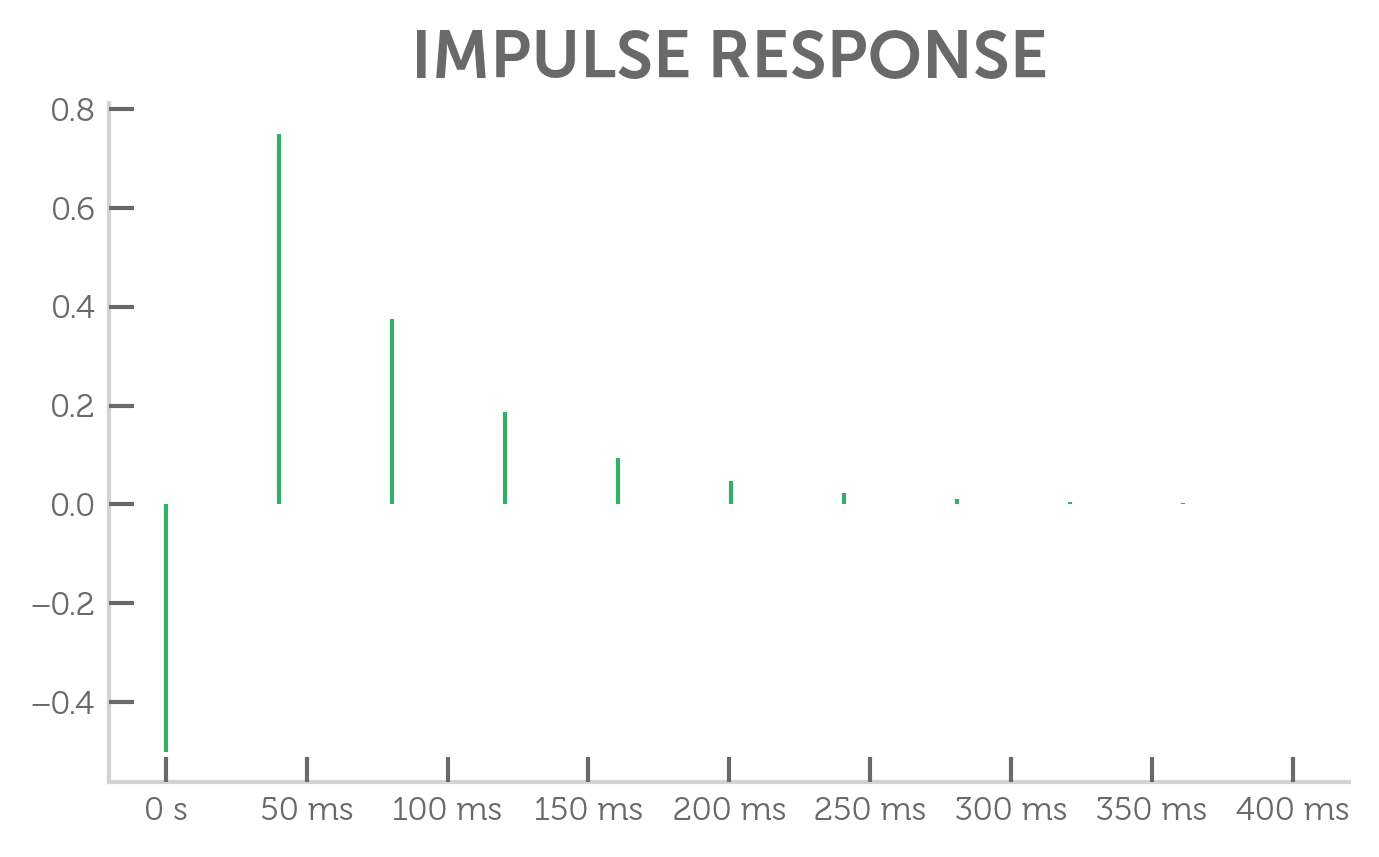

In [4]:
allpass_delay.clear()

time = 0.4
samples = fft.next_fast_len(int(time * sample_rate))
x = np.linspace(0.0, time, samples, endpoint=False)
impulse = signal.unit_impulse(x.size)

impulse_response = np.zeros(impulse.size)
for index, sample in enumerate(impulse):
    impulse_response[index] = allpass_delay.output
    allpass_delay.tick(sample)

plot_ir(x, impulse_response, 'C6')

plt.show()

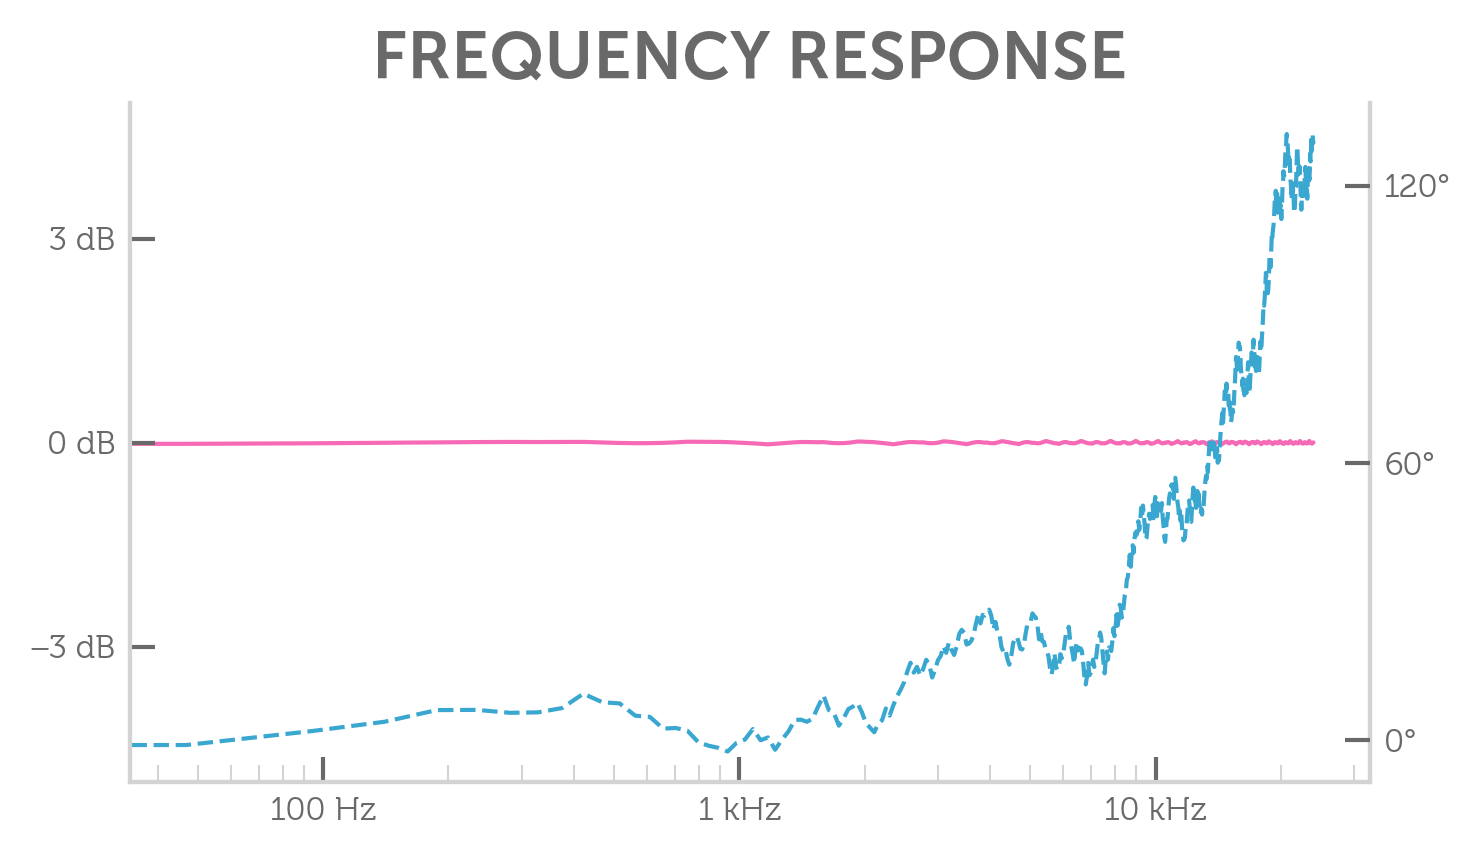

In [5]:
plot_fr(impulse_response, sample_rate, 'C15', 'C10', y1_lim=[-5, 5], y2_inc=60)

plt.show()


![Schroeder Reverb](img/schroeder_reverb.png)

In [6]:
class SchroederReverb:
    """Schroeder reverbator, as described in 'Natural Sounding Artificial Reverberation', Fig. 5"""

    def __init__(self, gain, delay_length, allpass_matrix, sample_rate):
        self.size = len(allpass_matrix)
        self.gain = gain
        self.output = 0.0

        self.allpass_reverb = [SchroederAllPass(sample_rate, allpass_matrix[allpass][0],
                               allpass_matrix[allpass][1]) for allpass in range(self.size)]

        self.delay = Delay(sample_rate, delay_length, [delay_length], 'hermite')

    def tick(self, input_):
        """Run reverb for 1 sample"""
        self.delay.tick(input_ + self.gain * self.allpass_reverb[-1].output)
        for index, allpass in enumerate(self.allpass_reverb):
            if index == 0:
                allpass.tick(self.delay.output)
            else:
                allpass.tick(self.allpass_reverb[index - 1].output)

        self.output = (
            self.allpass_reverb[-1].output * (1.0 - self.gain**2)) + (input_ * self.gain * -1.0)

    def clear(self):
        """Flush delay lines, setting all values to 0.0"""
        self.delay.clear()
        for allpass in self.allpass_reverb:
            allpass.clear()


In [7]:
input_file = "./input.wav"
output_file = "./reverb_output.wav"

with wave.open(input_file, "r") as wave_file:
    sample_rate = wave_file.getframerate()

kwargs = {
    'gain': 0.5,
    'delay_length': 43,
    'allpass_matrix': [[100, 0.5],
                       [68, -0.5],
                       [57, 0.5],
                       [19.7, 0.5],
                       [5.85, 0.5]],
    'sample_rate': sample_rate
}

reverb = SchroederReverb(**kwargs)

process_file(input_file, output_file, reverb)
display.Audio(filename=output_file)


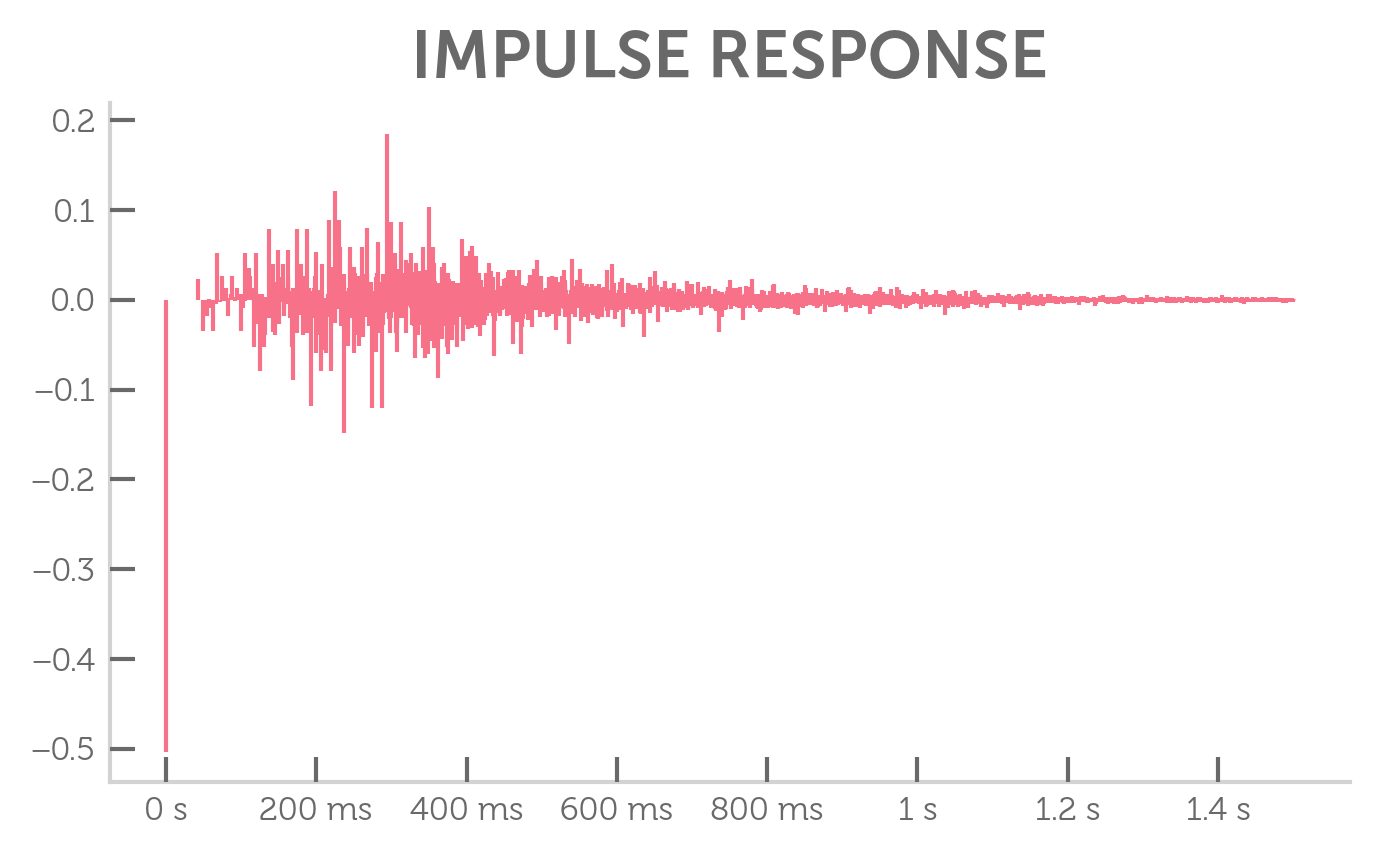

In [8]:
reverb.clear()

time = 1.5
samples = fft.next_fast_len(int(time * sample_rate))
x = np.linspace(0.0, time, samples, endpoint=False)
impulse = signal.unit_impulse(x.size)

impulse_response = np.zeros(impulse.size)
for index, sample in enumerate(impulse):
    reverb.tick(sample)
    impulse_response[index] = reverb.output

plot_ir(x, impulse_response, 'C0')

plt.show()


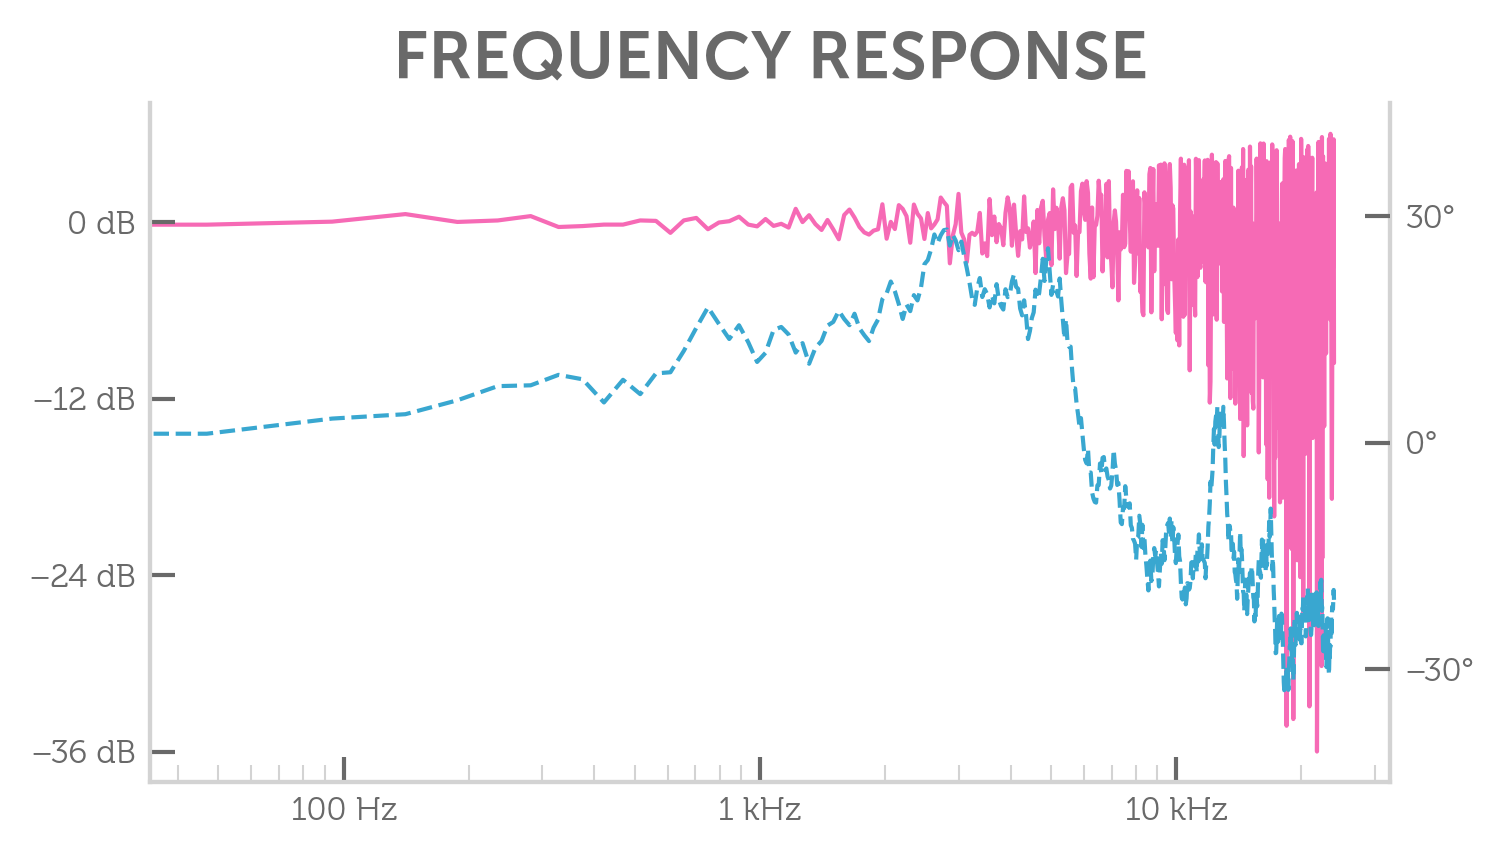

In [9]:
plot_fr(impulse_response, sample_rate, 'C15', 'C10', y1_inc=12, y2_lim=[-45, 45])

plt.show()
